# GPT-2 Adjective Representation PCA

Let's look at the representations induced in a noun after being described by various adjectives. 

We will sample adjectives from Webster's dictionary, and we will use a pre-defined single-token noun/prompt for now. 

An exciting extension for understanding the **temporality** of emotion in LLMs by examining structure in the representations of the noun after T tokens have passed. Will the strength of the "emotion signals" dissapate over time? Will we see commonality in the representations when projected along an "emotional access" (PCA dimension)? 

In [1]:
# Imports 
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 

from sklearn.decomposition import PCA

## Load GPT-2 


In [2]:
tokenizer = AutoTokenizer.from_pretrained("openai-community/gpt2")
tokenizer.pad_token = tokenizer.eos_token
model = AutoModelForCausalLM.from_pretrained("openai-community/gpt2").to('cuda')

In [3]:
# Sanity check: What is the model loss on this sample input sentence? 
input_str = "Bob is extremely abashed. Therefore, Bob" 
input_ids = tokenizer.encode(input_str, return_tensors="pt").to('cuda')

# Generate the output
output = model(input_ids, labels=input_ids)
loss = output.loss
print("Loss: ", loss.item())

Loss:  5.237336158752441


## Load Webster's Dictionary

We are going to pull the [Webster's Unabridged Dictionary](https://www.gutenberg.org/ebooks/29765)
from project Gutenberg and parse it to find adjectives. 

In [4]:
# download https://www.gutenberg.org/ebooks/29765.txt.utf-8 using requests
# check if Websters_English_Dictionary.txt exists
import os 
import requests

if not os.path.exists('Websters_English_Dictionary.txt'): 
    url = "https://www.gutenberg.org/ebooks/29765.txt.utf-8"
    response = requests.get(url)
    text = response.text
    print("Length of text response: ", len(text))

    # write to external text file 
    with open("Websters_English_Dictionary.txt", "w") as file:
        file.write(text)
else: 
    # load the text file
    print("Loading text file")
    with open("Websters_English_Dictionary.txt", "r") as file:
        text = file.read()

Loading text file


In [5]:
# regular expression to find all lines that have any number of capital letters 
# followed by any number of white space characters followed by the end of line. 
import re
pattern = r"[A-Z]+\s*$\n[^,]+, a\."
matches = re.findall(pattern, text, re.MULTILINE)
print("Number of adjective entry matches: ", len(matches))

Number of adjective entry matches:  25866


In [6]:
# picking out just the adjective
pattern = r"[A-Z]+\n"
adjectives_raw = [re.findall(pattern, x, re.MULTILINE)[0][:-1] for x in matches]

adjectives_raw = [x.lower() for x in adjectives_raw] # make lowercase

adjectives_raw[:15] # sanity check 

['abactinal',
 'abandoned',
 'abased',
 'abatable',
 'abatised',
 'abbatial',
 'abbatical',
 'abbreviate',
 'abbreviated',
 'abbreviatory',
 'abderian',
 'abdicable',
 'abdicant',
 'abdicative',
 'abditive']

## Dataset Generation 

Let's format it as something like a statement of fact about "James"

```
Bob is extremely abderian. Therefore, Bob 
                   {adjective}       {examine these representations}
```

In [7]:
# template_string = "Alice is extremely {}. Therefore, Alice"
template_string = "Bob is extremely {}, so Bob"

# generate a sentence for each adjective
sentences = [template_string.format(x) for x in adjectives_raw]

# tokenize the sentences 
tokenizer.pad_token = tokenizer.eos_token
input_ids = tokenizer(sentences, 
                      return_tensors="pt", 
                      padding=True, 
                      truncation=True, 
                      max_length=128, 
                      add_special_tokens=True, 
                      return_attention_mask=True)
input_ids.keys()

dict_keys(['input_ids', 'attention_mask'])

In [8]:
# let's add the labels to the input_ids dictionary -- 
# we want to predict the input_ids, but set -100 if it's a padding (eos) token 
input_ids['labels'] = input_ids.input_ids.clone()
input_ids['labels'][input_ids['labels'] == tokenizer.eos_token_id] = -100
input_ids['labels'] = input_ids['labels'].to('cuda')

input_ids['labels'][0,:]

tensor([18861,   318,  4457,   450,   529,  1292,    11,   523,  5811,  -100,
         -100,  -100,  -100], device='cuda:0')

In [9]:
input_ids['input_ids'][0,:]

tensor([18861,   318,  4457,   450,   529,  1292,    11,   523,  5811, 50256,
        50256, 50256, 50256])

In [10]:
input_ids['attention_mask'][0,:]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0])

Text(0.5, 1.0, 'Histogram of attention mask sums')

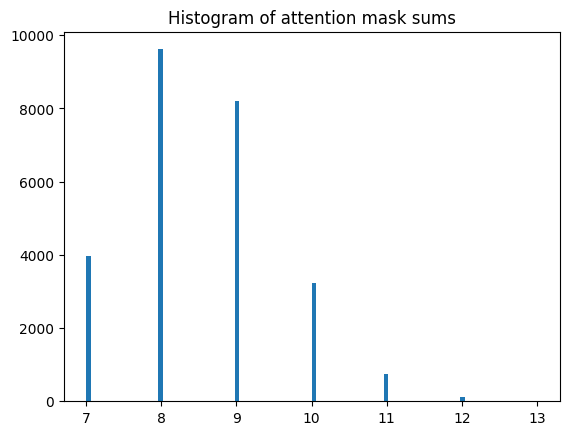

In [11]:
x = input_ids['attention_mask'].sum(1) 
# histogram of x
plt.hist(x.numpy(), bins=100)
plt.title("Histogram of attention mask sums")

In [12]:
print("SELECTING ONLY THE SENTENCES THAT HAVE N TOKENS")
selection_mask = x == 7

# select the sentences that have 10 tokens
input_ids['input_ids'] = input_ids['input_ids'][selection_mask]
input_ids['attention_mask'] = input_ids['attention_mask'][selection_mask]
input_ids['labels'] = input_ids['labels'][selection_mask]

# adjectives selection
adjectives = [adjectives_raw[i] for i in range(len(adjectives_raw)) if selection_mask[i]]

print("Number of selected sentences: ", input_ids['input_ids'].shape[0])

SELECTING ONLY THE SENTENCES THAT HAVE N TOKENS
Number of selected sentences:  3971


Let's filter for the low CE loss adjectives.

In [13]:
ce_losses = [] 

for i in tqdm(range(input_ids['input_ids'].shape[0])):
    input_id = input_ids['input_ids'][i].unsqueeze(0).to('cuda')
    attention_mask = input_ids['attention_mask'][i].unsqueeze(0).to('cuda')
    labels = input_ids['labels'][i].unsqueeze(0).to('cuda')
    output = model(input_id, attention_mask=attention_mask, labels=labels)
    ce_losses.append(output.loss.item())

100%|██████████| 3971/3971 [00:30<00:00, 130.28it/s]


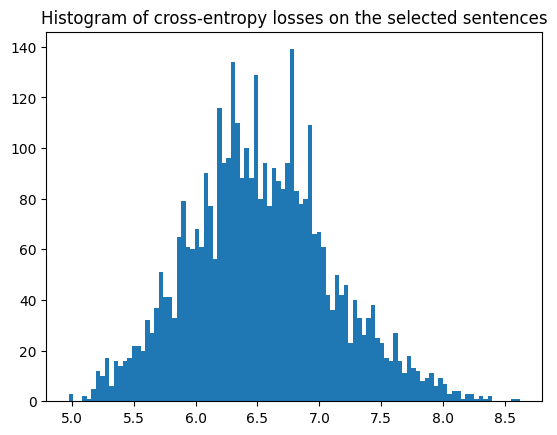

In [14]:
ce_losses = np.array(ce_losses)
plt.hist(ce_losses, bins=100)
plt.title("Histogram of cross-entropy losses on the selected sentences")
plt.show()

In [15]:
low_loss_mask = ce_losses < 6.0

In [16]:
# filter adjectives, input_ids, attention_mask, and labels 
# using the low_loss_mask
adjectives_filtered = [adjectives[i] for i in range(len(adjectives)) if low_loss_mask[i]]
input_ids['input_ids'] = input_ids['input_ids'][low_loss_mask]
input_ids['attention_mask'] = input_ids['attention_mask'][low_loss_mask]
input_ids['labels'] = input_ids['labels'][low_loss_mask]

print(f"Length of adjectives: {len(adjectives_filtered)}")

Length of adjectives: 721


In [17]:
def get_bob_vals(past_kvs): 
    """
    Args: 
        `past_kvs`: model output['past_key_values'] from running a batch of 
        left-padded sentences through the model.

        Accepts `past_kvs`, a tuple of length NUM_LAYERS (32), each containing a 
        2-long tuple (for keys and values respectively), each containing a torch 
        Tensor of shape [batch, num_heads, seq_len, head_dim] (for values). 

    Returns: 
        `bob_kvs`: list of length BATCH_SIZE with some numpy arrays representing 
        of shape [num_layers, num_heads, head_dim]
    """

    # iterate thru batch size 
    BATCH_SIZE = past_kvs[0][1].shape[0]

    batch_bob_values = []
    for batch_el in range(BATCH_SIZE): 
        # aggregate representations from across the layers 
        bob_numpy_arrays = []
        for layer in range(len(past_kvs)): 
            bob_layer_l_value = past_kvs[layer][1][batch_el, :, -1, :].detach().cpu().numpy()
            # print("Bob layer_l_value shape: ", bob_layer_l_value.shape)

            # unsqueeze on dimension zero
            bob_numpy_arrays.append(bob_layer_l_value[np.newaxis, ...])
        
        # merge on axis 0
        bob_numpy_arrays_conc = np.concatenate(bob_numpy_arrays, axis=0)
        # print("Bob numpy arrays shape (post-concatenation to combine layers)", bob_numpy_arrays_conc.shape)
        # bob_numpy_arrays now has shape n_layers = 32, n_heads = 8, embed_dim=128

        # add it to the list
        batch_bob_values.append(bob_numpy_arrays_conc)


    return batch_bob_values


In [18]:
# iterate thru input_ids
BATCH_SIZE = 1

past_values_bob = [] # list of length NUM_ADJECTIVES, each element is
                     # a numpy array of bob value reps of shape [num_layers=32, n_heads=8, embed_dim=128]

losses = []

print("Generating Bob representations...")
# pbar = tqdm(total=len(input_ids["input_ids"]) // BATCH_SIZE + 1)
pbar = tqdm(range(len(input_ids["input_ids"]) // BATCH_SIZE))
for i in pbar:
    batch_ids = input_ids["input_ids"][i * BATCH_SIZE: (i + 1) * BATCH_SIZE].to(model.device)
    batch_attn = input_ids["attention_mask"][i * BATCH_SIZE: (i + 1) * BATCH_SIZE].to(model.device)[:, :]
    batch_labels = input_ids["labels"][i * BATCH_SIZE: (i + 1) * BATCH_SIZE].to(model.device)
    # print("Batch ids shape (batch, ): ", batch_ids.shape)
    # print("Input string: ", tokenizer.decode(batch_ids[15, :]))
    # print(f"Final token: `{tokenizer.decode(batch_ids[0, -1:])}`")
    outputs = model.forward(batch_ids, return_dict=True, labels=batch_labels, attention_mask=batch_attn)
    # print("Output keys: ", outputs.keys())

    past_kvs = outputs['past_key_values']

    # print("Past key values (n_layers): ", len(past_kvs))
    # print("Batch size (reconstructed): ", past_kvs[0][1].shape[0])
    bob_numpy_arrays = get_bob_vals(past_kvs) # [batch_size], each a numpy array of shape [num_layers=32, n_heads=8, embed_dim=128]

    # let's add this to the past_values_bob 
    past_values_bob += bob_numpy_arrays


    # storing the loss value
    loss = outputs['loss'].detach().cpu().numpy()
    losses.append(loss)

    # update with loss value
    pbar.set_postfix({"loss": loss})

Generating Bob representations...


100%|██████████| 721/721 [00:06<00:00, 108.75it/s, loss=5.4731]   


In [19]:
tokenizer.batch_decode(input_ids['input_ids'][1:10, :])

['Bob is extremely abusive, so Bob<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>',
 'Bob is extremely accessible, so Bob<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>',
 'Bob is extremely accommodating, so Bob<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>',
 'Bob is extremely accomplished, so Bob<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>',
 'Bob is extremely accurate, so Bob<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>',
 'Bob is extremely active, so Bob<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>',
 'Bob is extremely adept, so Bob<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>',
 'Bob is extremely adorable, so Bob<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>',
 'Bob is extremely advanced, so Bob<|endoftext|><|endoftext|><|endo

In [20]:
print("Number of bob representations: ", len(past_values_bob))
print("Number of adjectives: ", len(adjectives))
print("Shape of individual bob value representation: ", past_values_bob[0].shape)
print("\t[num_layers=32, n_heads=8, embed_dim=128]")
print("Length of losses: ", len(losses))
print("Loss[0]: ", losses[0])

Number of bob representations:  721
Number of adjectives:  3971
Shape of individual bob value representation:  (12, 12, 64)
	[num_layers=32, n_heads=8, embed_dim=128]
Length of losses:  721
Loss[0]:  5.765722


In [21]:
print("Len of past_values_bob: ", len(past_values_bob))
print("Shape of past_values_bob[0]: ", past_values_bob[0].shape)
print("Length of losses: ", len(losses))

Len of past_values_bob:  721
Shape of past_values_bob[0]:  (12, 12, 64)
Length of losses:  721


## PCA on Bob Representations

Gotta flatten the past_values_bob[i] value reps, make a big ole matrix, and do 
PCA on it, and hope my computer doesn't explode. 

In [22]:
flat_past_values_bob = []
NUM_LAYERS = 5 # take reps from the first NUM_LAYERS layers

for i in range(len(past_values_bob)): 
    flat_past_values_bob.append(past_values_bob[i][:, :, :].flatten())

past_values_bob_matrix = np.array(flat_past_values_bob)
print("Past values bob matrix shape (num_adjectives, token_value_dim): ", past_values_bob_matrix.shape)

# save to disk 
np.save("bob_representations_flat.npy", past_values_bob_matrix)

Past values bob matrix shape (num_adjectives, token_value_dim):  (721, 9216)


In [23]:
losses_filtered = losses
past_values_bob_matrix_filtered = past_values_bob_matrix

In [24]:
# normalize each bob representation (by row)
past_values_bob_matrix_filtered_normalized = past_values_bob_matrix_filtered / np.linalg.norm(past_values_bob_matrix_filtered, axis=1)[:, np.newaxis]

np.linalg.norm(past_values_bob_matrix_filtered_normalized[0, :])

1.0

In [27]:
adjectives_filtered[:10]

['absent',
 'abusive',
 'accessible',
 'accommodating',
 'accomplished',
 'accurate',
 'active',
 'adept',
 'adorable',
 'advanced']

In [28]:
# doing pca 
# Initialize PCA to keep the first 3 principal components
pca = PCA(n_components=3)

# Fit PCA on your data and transform it to get the 3-dimensional representation
transformed_data = pca.fit_transform(past_values_bob_matrix_filtered_normalized)

# transformed_data now has shape [N, 3], where N is the number of examples
print("Transformed data shape:", transformed_data.shape)
print("First 3-dimensional representation:", transformed_data[0])


Transformed data shape: (721, 3)
First 3-dimensional representation: [-0.06071658 -0.00262229 -0.00278496]


In [29]:
# aldo run a t-sne
from sklearn.manifold import TSNE
tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(past_values_bob_matrix_filtered_normalized)

# tsne_results now has shape [N, 3], where N is the number of examples
print("TSNE results shape:", tsne_results.shape)
print("First 3-dimensional representation:", tsne_results[0])


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 721 samples in 0.003s...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[t-SNE] Computed neighbors for 721 samples in 0.541s...
[t-SNE] Computed conditional probabilities for sample 721 / 721
[t-SNE] Mean sigma: 0.030498
[t-SNE] KL divergence after 50 iterations with early exaggeration: 61.516678
[t-SNE] KL divergence after 300 iterations: 0.908133
TSNE results shape: (721, 3)
First 3-dimensional representation: [ 7.2493596  0.6732346 10.581374 ]


## Plotly Interactive Scatter Plot

We will output this as an HTML file you can view with the browser to explore the 
data space. 

In [31]:
import plotly.graph_objects as go

# Create a list of colors that scales with the losses 
final_losses = losses_filtered
final_data = transformed_data
final_adjectives = adjectives_filtered


colors = np.array(final_losses) - np.min(final_losses)
colors = colors / np.max(colors)


# Create a 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=final_data[:, 0],
    y=final_data[:, 1],
    z=final_data[:, 2],
    text=final_adjectives,  # Set the labels for each point
    mode='markers+text',  # Choose to have both markers and text
    marker=dict(
        size=5,
        color=colors,  # Set the color of each point
        opacity=0.8
    )
)])

# Customize the layout of the plot
fig.update_layout(
    title=f'GPT-2, top {len(final_losses)}: PCA on Bob reps in "Bob is extremely <adjective>. Therefore <Bob>" sentences',
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'
    )
)

# Export the plot as an HTML file
fig.write_html('bob_adjective_reps.html')

In [32]:
# scatter plot for t-sne
# Create a 3D scatter plot

final_tsne_data = tsne_results

fig = go.Figure(data=[go.Scatter3d(
    x=final_tsne_data[:, 0],
    y=final_tsne_data[:, 1],
    z=final_tsne_data[:, 2],
    text=final_adjectives,  # Set the labels for each point
    mode='markers+text',  # Choose to have both markers and text
    marker=dict(
        size=5,
        color=colors,  # Set the color of each point
        opacity=0.8
    )
)])

# Customize the layout of the plot
fig.update_layout(
    title=f'Mistral 7b, top {len(final_losses)}: T-SNE on Bob reps in "Bob is extremely <adjective>. Therefore <Bob>" sentences',
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'
    )
)

# Export the plot as an HTML file
fig.write_html('bob_adjective_reps_tsne.html')
